# Monte Carlo Illustration of Confidence Intervals

This notebook is designed to illustrate some of the statistical properties of confidence intervals and the estimators they're based on.  It considers a random sample $\{X_i|i=1,\ldots,n\}$ of size $n$ from a normal distribution $N(\mu,\sigma^2)$.  To simulate the probabilities, it will use a Monte Carlo method, randomly constructing $N$ samples $\{\{x^{(I)}_i|i=1,\ldots,n\}|I=1,\ldots,N\}$, each of size $n$.

First, some python boilerplate:

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
from scipy import stats
rcParams['figure.figsize'] = (8.0, 8.0)
rcParams['font.size'] = 14

We choose values for the parameters of the distribution, the sample, and the Monte Carlo.  We also seed the random number generator, so that our results will be reproducible.  We also explicitly calculate $\mu$ and $\sigma$ as the mean and standard deviation of the probability distribution.  The advantage in this is that we could use a different family of distributions, such as `stats.gamma(alpha,scale=beta)` and automatically have the correct $\mu$ and $\sigma$ calculated from those parameters.

In [3]:
mu=10
sigma=2
mydist = stats.norm(loc=mu,scale=sigma)
mu = mydist.mean()
sigma = mydist.std()
print('Distribution has true mean %g and standard deviation %g' % (mu,sigma))
n=10
N=10**4
random.seed(20190129)
x_Ii=mydist.rvs(size=(N,n))

Distribution has true mean 10 and standard deviation 2


We now have $N$ samples of size $n$ (stored in an $N\times n$ array).  We can plot the first few of them to get a sense of what each possible realization of the data looks like:

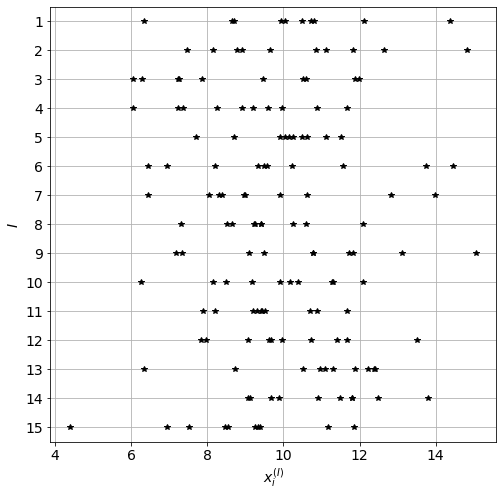

In [4]:
Nview = 15
Iview = arange(Nview)
plot(x_Ii[Iview,:],1+Iview[:,None],'k*');
ylim(Nview+0.5,0.5);
yticks(1+Iview);
xlabel(r'$x^{(I)}_i$');
ylabel('$I$');
grid(True);

## Normal Confidence Intervals

### Behavior of statistics used

We know that the sample mean $\overline{X}$ is a random variable (statistic) with expectation value $E(\overline{X})=\mu_{\overline{X}}=\mu$ and variance $V(\overline{X})=\sigma_{\overline{X}}^2=\sigma^2/n$.  We examine the behavior by taking the sample mean of each of our Monte Carlo samples, $\overline{x}^{(I)}=\frac{1}{n}\sum_{i=1}^n x_i^{(I)}$. 

In [5]:
xbar_I = mean(x_Ii,axis=-1)
mu_xbar = mu
sigma_xbar = sigma/sqrt(n)

In [6]:
print('Monte carlo mean of Xbar is %g; theoretical is %g' % (mean(xbar_I),mu_xbar))
print('Monte carlo std of Xbar is %g; theoretical is %g' % (std(xbar_I),sigma_xbar))

Monte carlo mean of Xbar is 9.99546; theoretical is 10
Monte carlo std of Xbar is 0.637385; theoretical is 0.632456


Since the sample was drawn from a normal distribution, we expect that the sample mean will also be a normally-distributed random variable.  We can check this by plotting a histogram of the Monte Carlo sample means $\{\overline{x}^{(I)}\}$ and seeing that it does indeed look a lot like the appropriately-scaled $N(\mu,\sigma^2/2)$ pdf:

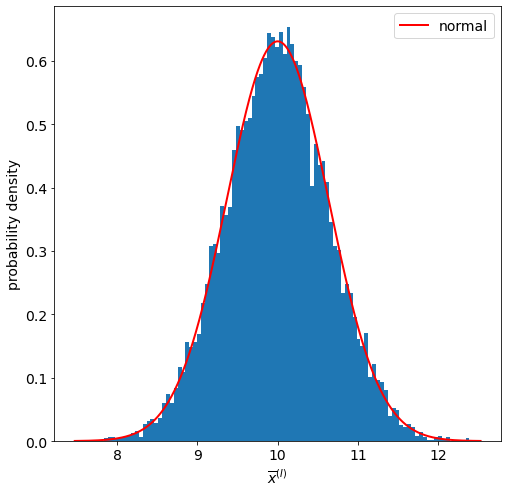

In [7]:
hist(xbar_I,bins=int(sqrt(N)),density=True);
x = linspace(mu_xbar-4*sigma_xbar,mu_xbar+4*sigma_xbar,1000)
plot(x,stats.norm(loc=mu_xbar,scale=sigma_xbar).pdf(x),'r-',linewidth=2,label='normal');
legend();
xlabel('$\overline{x}^{(I)}$');
ylabel('probability density');

Likewise, if we standardize $\overline{X}$ using $\mu_{\overline{X}}$ and $\sigma_{\overline{X}}$, we can check that the resulting statistic is standard normal, as predicted by the theory:

In [8]:
z_I = (xbar_I - mu_xbar)/sigma_xbar

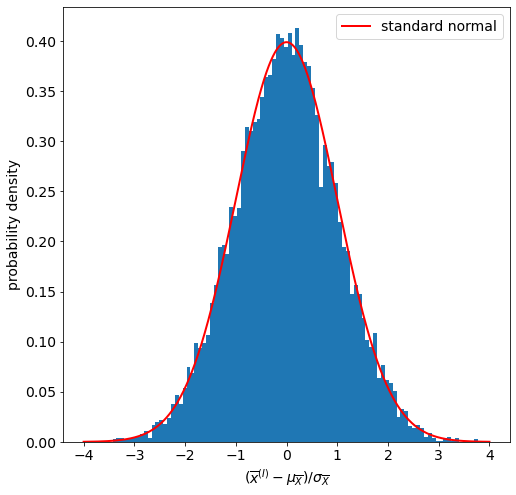

In [9]:
hist(z_I,bins=int(sqrt(N)),density=True);
z = linspace(-4,4,1000)
plot(z,stats.norm.pdf(z),'r-',linewidth=2,label='standard normal');
legend();
xlabel(r'$(\overline{x}^{(I)}-\mu_{\overline{X}})/\sigma_{\overline{X}}$');
ylabel('probability density');

The construction of the confidence interval says that the statistic $(\overline{X}-\mu)/(\sigma/\sqrt{n})$ has a probability $1-\alpha$ to lie between the percentiles $-z_{\alpha/2}$ and $-z_{\alpha/2}$ (which we can also calculate for a desired confidence level using Python's stats package.

We can get the fraction of Monte Carlo values satisfying a particular inequality, in numpy, by creating an array of `True` (1) and `False` (0) values.  The sum of this array is the number of times the inequality is satisfied, and the average is the fraction.  So for example, the fraction of Monte Carlo iterations with a supposedly standard normal quantity above $z_{\alpha}$ should be close to $\alpha$.

In [10]:
alpha = 1 - 0.95
zalpha_2 = stats.norm.isf(alpha/2)
print("%.1fth percentile of standard normal is %g" % (100*(1-alpha/2),zalpha_2))
print('Fraction of z scores above %g is %g' % (zalpha_2,mean(z_I>zalpha_2)))
print('Fraction of z scores below %g is %g' % (-zalpha_2,mean(z_I<-zalpha_2)))
print('Fraction of z scores between %g and %g is %g' % (-zalpha_2,zalpha_2,mean((z_I>-zalpha_2)*(z_I<zalpha_2))))

97.5th percentile of standard normal is 1.95996
Fraction of z scores above 1.95996 is 0.026
Fraction of z scores below -1.95996 is 0.0256
Fraction of z scores between -1.95996 and 1.95996 is 0.9484


Incidentally, in all of these estimated probabilities, we don't necessarily expect to find exactly the specified percentage.  If each confidence interval has a probability $1-\alpha$ of containing the true value, the number out of $N$ which actually do will be a ${\rm Bin}(N,1-\alpha)$ random variable, which will have an expectation value of $N(1-\alpha)$, a variance of $N(1-\alpha)\alpha$ and a standard deviation $\sqrt{N(1-\alpha)\alpha}$ (which is approximately $\sqrt{N\alpha}$ when $\alpha$ is small), so the fraction of confidence intervals containing the true value will have expectation value $1-\alpha$, variance $(1-\alpha)\alpha/N$ and standard deviation $\sqrt{(1-\alpha)\alpha/N}$ 

In [11]:
print('Expected fraction of %d Monte Carlo trials with %d%% CI containing true value is %g +/- %g'
      % (N,100*(1-alpha),1-alpha,sqrt((1-alpha)*alpha/N)))

Expected fraction of 10000 Monte Carlo trials with 95% CI containing true value is 0.95 +/- 0.00217945


### Construction and behavior of confidence intervals

Now we're ready to construct the confidence interval corresponding to each Monte Carlo iteration.  The $I$th confidence interval is from $\overline{x}^{(I)}-z_{\alpha/2}\sigma/\sqrt{n}$ to $\overline{x}^{(I)}+z_{\alpha/2}\sigma/\sqrt{n}$:

In [12]:
zCIlo_I = xbar_I - zalpha_2 * sigma / sqrt(n)
zCIhi_I = xbar_I + zalpha_2 * sigma / sqrt(n)

We plot the confidence intervals for the first few $I$s.  The true value of $\mu$ is indicaed by the vertical red line; most of the confidence interviews include it, but a few don't:

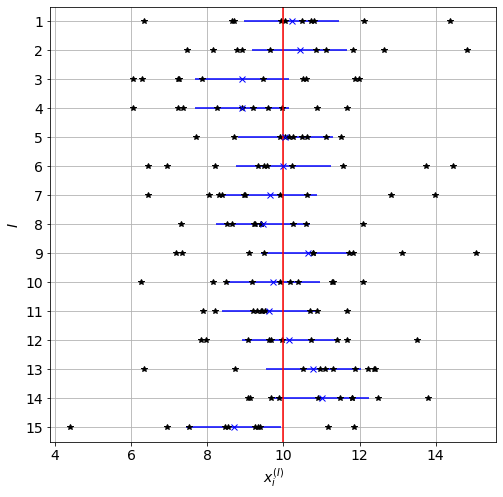

In [13]:
Nview = 15
Iview = np.arange(Nview)
plot(x_Ii[Iview,:],1+Iview[:,None],'k*');
# plot(xbar_I[Iview],1+Iview,'bx')
errorbar(xbar_I[Iview],1+Iview,xerr=zalpha_2 * sigma / sqrt(n),fmt='bx')
plot([mu,mu],[0,Nview+1],'r-')
ylim(Nview+0.5,0.5);
yticks(1+Iview);
xlabel(r'$x^{(I)}_i$');
ylabel('$I$');
grid(True);

We can count up how many confience intervals are entirely above or below $\mu$, and how many include it, thus verifying the fundamental definition of the confidence interval:

In [14]:
print('Fraction of %d%% CIs entirely below %g is %g' % (100*(1-alpha),mu,mean(zCIhi_I<mu)))
print('Fraction of %d%% CIs entirely above %g is %g' % (100*(1-alpha),mu,mean(zCIlo_I>mu)))
print('Fraction of %d%% CIs containing %g is %g' % (100*(1-alpha),mu,mean((zCIlo_I<mu)*(zCIhi_I>mu))))

Fraction of 95% CIs entirely below 10 is 0.0256
Fraction of 95% CIs entirely above 10 is 0.026
Fraction of 95% CIs containing 10 is 0.9484


## Student-$t$ Confidence Intervals

### Behavior of statistics used

Now we consider the case where the true variance $\sigma^2$ is unknown, and we estimate it with the sample variance $S^2=\frac{1}{n-1}\sum_{i=1}^n(X_i-\overline{X})^2$, which we know has expectation value $E(S^2)=\sigma^2$.  We check this by constructing the sample standard deviation $s^{(I)}=\sqrt{\frac{1}{n-1}\sum_{i=1}^n(x_i^{(I)}-\overline{x}^{(I)})^2}$ from each Monte Carlo sample:

In [15]:
s_I = std(x_Ii,axis=-1,ddof=1)

In [16]:
print('Monte carlo mean of S^2 is %g; theoretical is %g' % (mean(s_I**2),sigma**2))

Monte carlo mean of S^2 is 3.99287; theoretical is 4


Note that although $S^2$ is an unbiased estimator of $\sigma^2$, $S$ is generally not an unbiased estimator of $\sigma$:

In [17]:
print('Monte carlo mean of S is %g; unbiased would be %g' % (mean(s_I),sigma))

Monte carlo mean of S is 1.94238; unbiased would be 2


We construct the "pivot variable" $T=\frac{\overline{X}-\mu}{\sqrt{S^2/n}}$, which the theory tells us should be Student-t distributed with $n-1$ degrees of freedom:

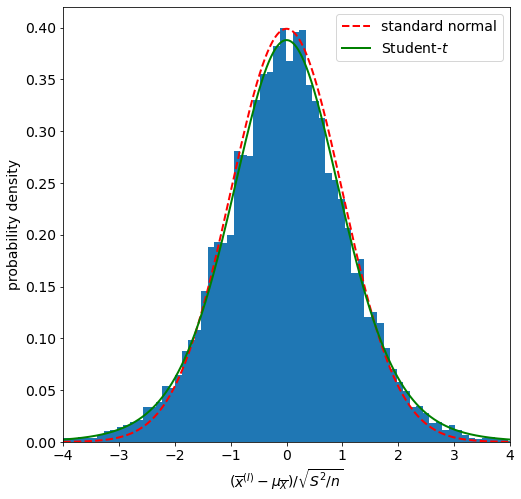

In [18]:
t_I = (xbar_I - mu_xbar)/(s_I/sqrt(n))
hist(t_I,bins=int(sqrt(N)),density=True);
t = linspace(-4,4,1000)
plot(t,stats.norm.pdf(t),'r--',linewidth=2,label='standard normal');
plot(t,stats.t(df=n-1).pdf(t),'g-',linewidth=2,label=r'Student-$t$');
legend();
xlabel(r'$(\overline{x}^{(I)}-\mu_{\overline{X}})/\sqrt{S^2/n}$');
ylabel('probability density');
xlim(-4,4);

You can sort of convince yourself that the Student-$t$ pdf is a closer approximation to the histogram, especially out in the tails.

We can construct the Student-$t$ percentiles, and verify that those are close to being the corresponding percentiles of the Monte Carlo ensemble.

In [19]:
talpha_2 = stats.t(df=n-1).isf(alpha/2)
print("%.1fth percentile of Student-t with %d dof is %g" % (100*(1-alpha/2),n-1,talpha_2))
print('Fraction of t scores above %g is %g' % (talpha_2,mean(t_I>talpha_2)))
print('Fraction of t scores above %g is %g' % (zalpha_2,mean(t_I>zalpha_2)))
print('Fraction of t scores below %g is %g' % (-talpha_2,mean(t_I<-talpha_2)))
print('Fraction of t scores below %g is %g' % (-zalpha_2,mean(t_I<-zalpha_2)))
print('Fraction of t scores between %g and %g is %g' % (-talpha_2,talpha_2,mean((t_I>-talpha_2)*(t_I<talpha_2))))
print('Fraction of t scores between %g and %g is %g' % (-zalpha_2,zalpha_2,mean((t_I>-zalpha_2)*(t_I<zalpha_2))))

97.5th percentile of Student-t with 9 dof is 2.26216
Fraction of t scores above 2.26216 is 0.0237
Fraction of t scores above 1.95996 is 0.0393
Fraction of t scores below -2.26216 is 0.0262
Fraction of t scores below -1.95996 is 0.0413
Fraction of t scores between -2.26216 and 2.26216 is 0.9501
Fraction of t scores between -1.95996 and 1.95996 is 0.9194


You can see that the $t$ distribution percentiles are close to the corresponding percentiles of the Monte Carlo ensemble, which is not the case for the standard normal percentiles.

### Construction and behavior of confidence intervals

Now we're ready to construct the confidence interval corresponding to each Monte Carlo iteration.  The $I$th confidence interval is from $\overline{x}^{(I)}-t_{\alpha/2,n-1}s^{(I)}/\sqrt{n}$ to $\overline{x}^{(I)}+t_{\alpha/2,n-1}s^{(I)}/\sqrt{n}$:

In [20]:
tCIlo_I = xbar_I - talpha_2 * s_I / sqrt(n)
tCIhi_I = xbar_I + talpha_2 * s_I / sqrt(n)

We plot the confidence intervals for the first few $I$s. The true value of $\mu$ is indicaed by the vertical red line.

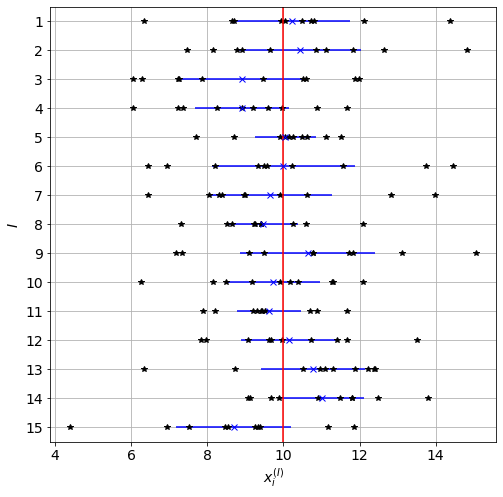

In [21]:
Nview = 15
Iview = np.arange(Nview)
plot(x_Ii[Iview,:],1+Iview[:,None],'k*');
errorbar(xbar_I[Iview],1+Iview,xerr=talpha_2 * s_I[Iview] / sqrt(n),fmt='bx')
plot([mu,mu],[0,Nview+1],'r-')
ylim(Nview+0.5,0.5);
yticks(1+Iview);
xlabel(r'$x^{(I)}_i$');
ylabel('$I$');
grid(True);

As it turns out, it's a while into the Monte Carlo ensemble before you get one that doesn't include $\mu$.  We can see where that is and start the plot there to illustrate how the confidence intervals can miss:

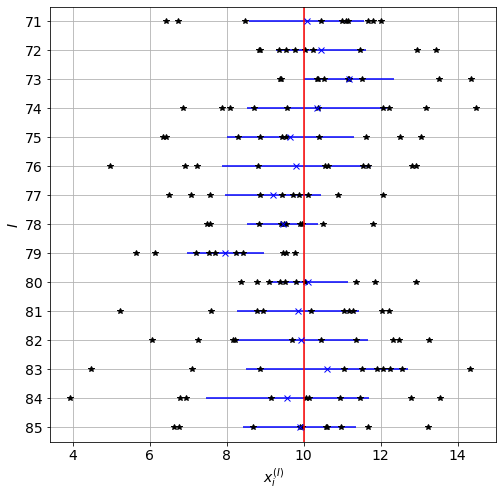

In [22]:
Iview = arange(N)[logical_not((tCIlo_I<mu)*(tCIhi_I>mu))][0] - 2 + arange(Nview)
plot(x_Ii[Iview,:],1+Iview[:,None],'k*');
errorbar(xbar_I[Iview],1+Iview,xerr=talpha_2 * s_I[Iview] / sqrt(n),fmt='bx')
plot([mu,mu],[Iview[0]+0.5,Iview[-1]+1.5],'r-')
ylim(Iview[-1]+1.5,Iview[0]+0.5);
yticks(1+Iview);
xlabel(r'$x^{(I)}_i$');
ylabel('$I$');
grid(True);

In any event, we can count the confidence intervals include $\mu$, and verify that they are correctly constructed:

In [23]:
print('Fraction of %d%% CIs entirely below %g is %g' % (100*(1-alpha),mu,mean(tCIhi_I<mu)))
print('Fraction of %d%% CIs entirely above %g is %g' % (100*(1-alpha),mu,mean(tCIlo_I>mu)))
print('Fraction of %d%% CIs containing %g is %g' % (100*(1-alpha),mu,mean((tCIlo_I<mu)*(tCIhi_I>mu))))

Fraction of 95% CIs entirely below 10 is 0.0262
Fraction of 95% CIs entirely above 10 is 0.0237
Fraction of 95% CIs containing 10 is 0.9501


## Confidence intervals for $\sigma$

### Behavior of statistics used

We know from intro stats (again, the single most important example of a chi-squared random variable is the sum of squares of independent standard normal random variables) that that
$$
U=\sum_{i=1}^n\frac{(X_i-\mu)^2}{\sigma^2}
$$
is a chi-squared random variable with $n$ degrees of freedom, which means among other things that $E(U)=n$ and $V(U)=2n$.  We can check this using our Monte Carlo sample and constructing
$$
u^{(I)} = \sum_{i=1}^n\frac{(x_i^{(I)}-\mu)^2}{\sigma^2}
$$

In [24]:
u_I = sum((x_Ii-mu)**2,axis=-1)/sigma**2

In [25]:
print('Monte carlo mean of U is %g; theoretical is %g' % (mean(u_I),n))
print('Monte carlo var of U is %g; theoretical is %g' % (var(u_I),2*n))

Monte carlo mean of U is 9.99965; theoretical is 10
Monte carlo var of U is 20.7494; theoretical is 20


We can plot the histogram from the Monte Carlo samples and verify that it does look like the chi-squared pdf:

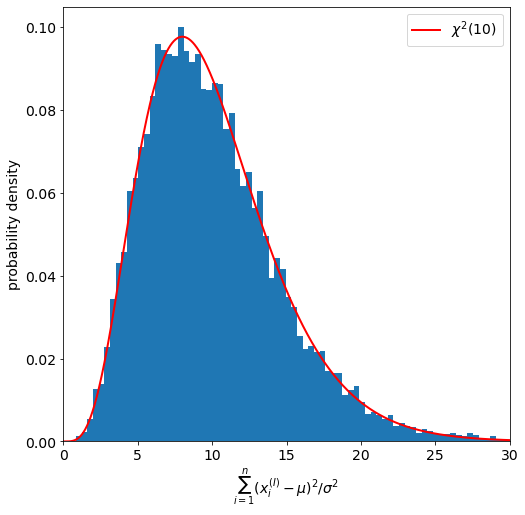

In [26]:
hist(u_I,bins=int(sqrt(N)),density=True);
u = linspace(0,3*n,1000)
plot(u,stats.chi2(df=n).pdf(u),'r-',linewidth=2,label=(r'$\chi^2(%d)$' % n));
legend();
xlabel(r'$\sum_{i=1}^n(x_i^{(I)}-\mu)^2/\sigma^2$');
ylabel('probability density');
xlim(0,3*n);

One of the results of Student's theorem is that
$$
W=\sum_{i=1}^n\frac{(X_i-\overline{X})^2}{\sigma^2}
$$
is a chi-squared random variable with $n-1$ degrees of freedom, which means among other things that $E(U)=n-1$ and $V(U)=2(n-1)$.  We can check this using our Monte Carlo sample and constructing
$$
w^{(I)} = \sum_{i=1}^n\frac{(x_i^{(I)}-\overline{x}^{(I)})^2}{\sigma^2}
$$

In [27]:
w_I = sum((x_Ii-xbar_I[:,None])**2,axis=-1)/sigma**2

In [28]:
print('Monte carlo mean of W is %g; theoretical is %g' % (mean(w_I),n-1))
print('Monte carlo var of W is %g; theoretical is %g' % (var(w_I),2*(n-1)))

Monte carlo mean of W is 8.98395; theoretical is 9
Monte carlo var of W is 18.4493; theoretical is 18


We can plot the histogram from the Monte Carlo samples and verify that it does look like the chi-squared pdf with $n-1$, **not** $n$, degrees of freedom:

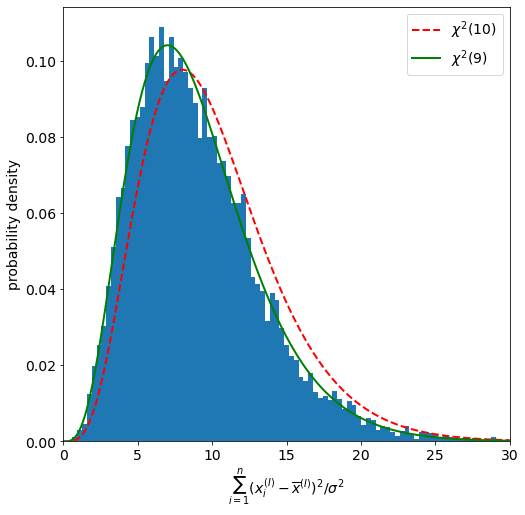

In [29]:
hist(w_I,bins=int(sqrt(N)),density=True);
w = linspace(0,3*n,1000)
plot(w,stats.chi2(df=n).pdf(w),'r--',linewidth=2,label=(r'$\chi^2(%d)$' % n));
plot(w,stats.chi2(df=n-1).pdf(w),'g-',linewidth=2,label=(r'$\chi^2(%d)$' % (n-1)));
legend();
xlabel(r'$\sum_{i=1}^n(x_i^{(I)}-\overline{x}^{(I)})^2/\sigma^2$');
ylabel('probability density');
xlim(0,3*n);

To give a bit of a sense what the "degrees of freedom" *mean*, we can look at the Monte Carlo samples again, and see how far they are from $\mu$ versus $\overline{x}^{(I)}$:

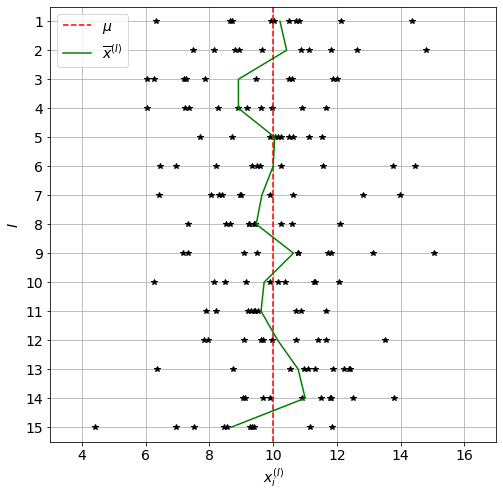

In [30]:
Nview = 15
Iview = np.arange(Nview)
plot(x_Ii[Iview,:],1+Iview[:,None],'k*');
plot([mu,mu],[0,Nview+1],'r--',label=r'$\mu$');
plot(xbar_I[Iview],1+Iview,'g-',label=r'$\overline{x}^{(I)}$');
ylim(Nview+0.5,0.5);
yticks(1+Iview);
xlabel(r'$x^{(I)}_i$');
ylabel('$I$');
legend(loc='upper left');
xlim(3,17)
grid(True);

We can see that the summed squared distance from the points in sample $I$ to the distribution mean $\mu$ (red dashed line) is going to be larger than the summed squared distance from the points in sample $I$ to the sample mean $\overline{x}^{(I)}$ for that sample, because the sample mean uses the information about where the points in that sample are located.  We can also get a sense of this by showing the respective squared distances in each case:

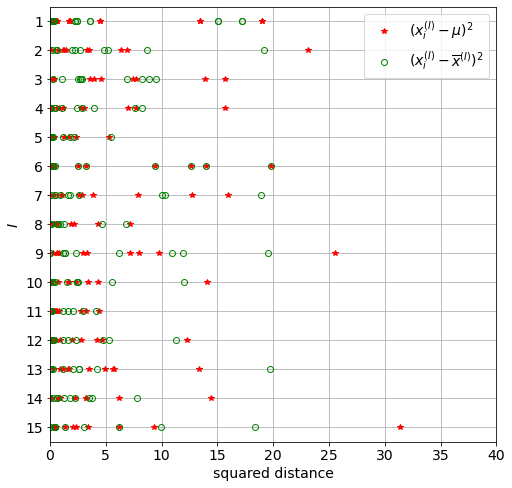

In [31]:
Nview = 15
Iview = np.arange(Nview)
plot((x_Ii[0,:]-mu)**2,ones(n),'r*',mfc='r',mec='r',label=r'$(x^{(I)}_i-\mu)^2$');
plot((x_Ii[0,:]-xbar_I[0])**2,ones(n),'go',mfc='None',mec='g',label=r'$(x^{(I)}_i-\overline{x}^{(I)})^2$');
plot((x_Ii[Iview,:]-mu)**2,1+Iview[:,None],'r*',mfc='r',mec='r');
plot((x_Ii[Iview,:]-xbar_I[Iview,None])**2,1+Iview[:,None],'go',mfc='None',mec='g');
ylim(Nview+0.5,0.5);
yticks(1+Iview);
xlabel('squared distance');
ylabel('$I$');
legend(loc='upper right',numpoints=1);
xlim(0,40);
grid(True);

Now let's get the percentiles of the chi-squared distribution.  Note that that we have to get both $\chi^2_{1-\alpha/2,n-1}$ and $\chi^2_{\alpha/2,n-1}$ because the chi-squared distribution is not symmetric:

In [32]:
chisq1malpha_2 = stats.chi2(df=n-1).ppf(alpha/2)
chisqalpha_2 = stats.chi2(df=n-1).isf(alpha/2)
print("%.1fth percentile of chisq(%d) is %g" % (100*(alpha/2),n-1,chisq1malpha_2))
print("%.1fth percentile of chisq(%d) is %g" % (100*(1-alpha/2),n-1,chisqalpha_2))
print('Fraction of chisq scores above %g is %g' % (chisqalpha_2,mean(w_I>chisqalpha_2)))
print('Fraction of chisq scores below %g is %g' % (chisq1malpha_2,mean(w_I<chisq1malpha_2)))
print('Fraction of chisq scores between %g and %g is %g'
      % (chisq1malpha_2,chisqalpha_2,mean((w_I>chisq1malpha_2)*(w_I<chisqalpha_2))))

2.5th percentile of chisq(9) is 2.70039
97.5th percentile of chisq(9) is 19.0228
Fraction of chisq scores above 19.0228 is 0.028
Fraction of chisq scores below 2.70039 is 0.0255
Fraction of chisq scores between 2.70039 and 19.0228 is 0.9465


### Construction and behavior of confidence intervals

Now we're ready to construct the confidence interval corresponding to each Monte Carlo iteration.  The $I$th confidence interval for $\sigma^2$ is from $(n-1)(s^{(I)})^2/\chi^2_{\alpha/2,n-1}$ to $(n-1)(s^{(I)})^2/\chi^2_{1-\alpha/2,n-1}$.

In [33]:
chisqCIlo_I = (n-1)*s_I**2 / chisqalpha_2
chisqCIhi_I = (n-1)*s_I**2 / chisq1malpha_2

We plot the confidence intervals for the first few $I$s. The true value of $\sigma^2$ is indicaed by the vertical red line.

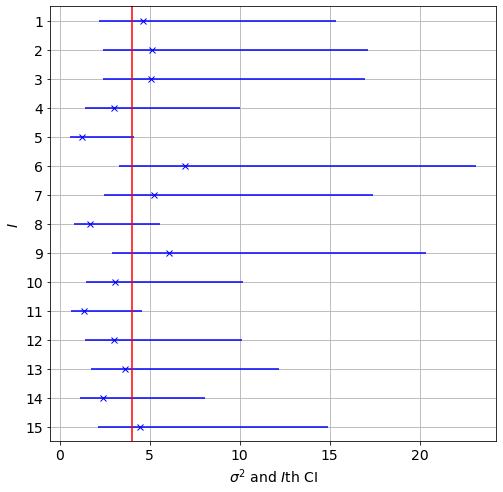

In [34]:
Nview = 15
Iview = np.arange(Nview)
chisqCIlobar_I = s_I**2 - chisqCIlo_I
chisqCIhibar_I = chisqCIhi_I - s_I**2
errorbar(s_I[Iview]**2,1+Iview,xerr=[chisqCIlobar_I[Iview],chisqCIhibar_I[Iview]],fmt='bx')
plot([sigma**2,sigma**2],[0,Nview+1],'r-')
ylim(Nview+0.5,0.5);
yticks(1+Iview);
xlabel(r'$\sigma^2$ and $I$th CI');
ylabel('$I$');
grid(True);

The confidence intervals look a bit funny because the procedure is multiplicative, but if we plot the variance on a logarithmic scale, it becomes apparent that the confidence intervals are all the same "width":

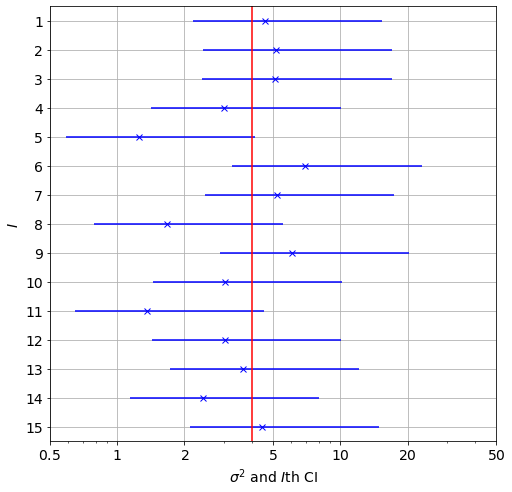

In [35]:
Nview = 15
Iview = np.arange(Nview)
errorbar(s_I[Iview]**2,1+Iview,xerr=[chisqCIlobar_I[Iview],chisqCIhibar_I[Iview]],fmt='bx')
plot([sigma**2,sigma**2],[0,Nview+1],'r-')
ylim(Nview+0.5,0.5);
xscale('log')
yticks(1+Iview);
tickvals=[0.5,1,2,5,10,20,50]
ticklabs=[('$%g$' % val) for val in tickvals]
xticks(tickvals,ticklabs)
xlim(0.5,50)
xlabel(r'$\sigma^2$ and $I$th CI');
ylabel('$I$');
grid(True);

We again find that this set of confidence intervals all happen to contain the true value, but we can plot some that don't:

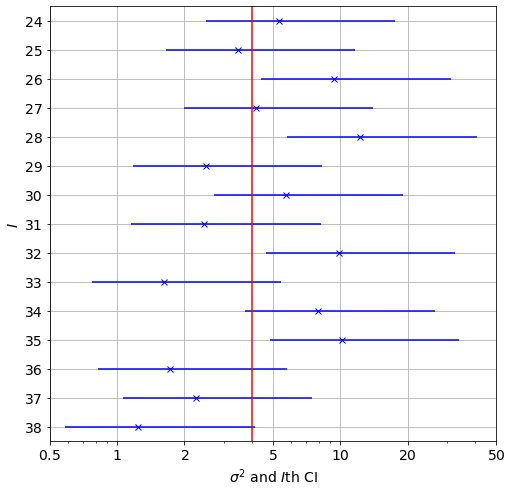

In [36]:
Iview = arange(N)[logical_not((chisqCIlo_I<sigma**2)*(chisqCIhi_I>sigma**2))][0] - 2 + arange(Nview)
errorbar(s_I[Iview]**2,1+Iview,xerr=[chisqCIlobar_I[Iview],chisqCIhibar_I[Iview]],fmt='bx')
plot([sigma**2,sigma**2],[Iview[-1]+1.5,Iview[0]+0.5],'r-')
ylim(Iview[-1]+1.5,Iview[0]+0.5);
xscale('log')
yticks(1+Iview);
tickvals=[0.5,1,2,5,10,20,50]
ticklabs=[('$%g$' % val) for val in tickvals]
xticks(tickvals,ticklabs)
xlim(0.5,50)
xlabel(r'$\sigma^2$ and $I$th CI');
ylabel('$I$');
grid(True);

One nice feature of the logarithmic scale is that the plot looks the same whether we show the confidence interval for $\sigma^2$ or for $\sigma$:

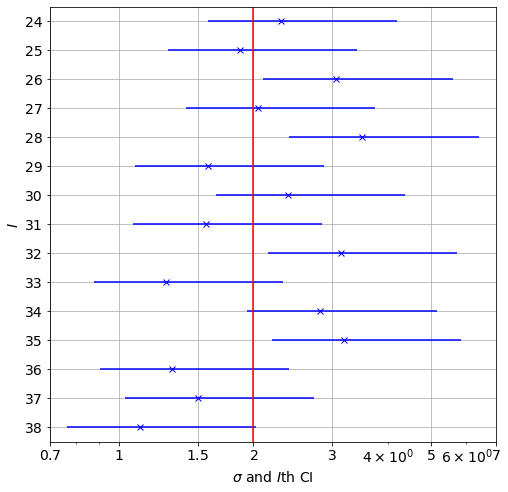

In [37]:
chiCIlo_I = sqrt(chisqCIlo_I)
chiCIhi_I = sqrt(chisqCIhi_I)
chiCIlobar_I = s_I - chiCIlo_I
chiCIhibar_I = chiCIhi_I - s_I
errorbar(s_I[Iview],1+Iview,xerr=[chiCIlobar_I[Iview],chiCIhibar_I[Iview]],fmt='bx')
plot([sigma,sigma],[Iview[-1]+1.5,Iview[0]+0.5],'r-')
ylim(Iview[-1]+1.5,Iview[0]+0.5);
xscale('log')
yticks(1+Iview);
tickvals=[0.7,1,1.5,2,3,5,7]
ticklabs=[('$%g$' % val) for val in tickvals]
xticks(tickvals,ticklabs)
xlim(0.7,7)
xlabel(r'$\sigma$ and $I$th CI');
ylabel('$I$');
grid(True);

And finally, we can show that the confidence intervals contain the true value approximately the correct percentage of the time:

In [38]:
print('Fraction of %d%% sigma^2 CIs entirely below %g is %g' % (100*(1-alpha),sigma**2,mean(chisqCIhi_I<sigma**2)))
print('Fraction of %d%% sigma^2 CIs entirely above %g is %g' % (100*(1-alpha),sigma**2,mean(chisqCIlo_I>sigma**2)))
print('Fraction of %d%% sigma^2 CIs containing %g is %g'
      % (100*(1-alpha),sigma,mean((chisqCIlo_I<sigma**2)*(chisqCIhi_I>sigma**2))))
print('Fraction of %d%% sigma CIs entirely below %g is %g' % (100*(1-alpha),sigma,mean(sqrt(chisqCIhi_I)<sigma)))
print('Fraction of %d%% sigma CIs entirely above %g is %g' % (100*(1-alpha),sigma,mean(sqrt(chisqCIlo_I)>sigma)))
print('Fraction of %d%% sigma CIs containing %g is %g'
      % (100*(1-alpha),sigma,mean((sqrt(chisqCIlo_I)<sigma)*(sqrt(chisqCIhi_I)>sigma))))

Fraction of 95% sigma^2 CIs entirely below 4 is 0.0255
Fraction of 95% sigma^2 CIs entirely above 4 is 0.028
Fraction of 95% sigma^2 CIs containing 2 is 0.9465
Fraction of 95% sigma CIs entirely below 2 is 0.0255
Fraction of 95% sigma CIs entirely above 2 is 0.028
Fraction of 95% sigma CIs containing 2 is 0.9465
